# Basic Circuit Identities

In [1]:
from qiskit import QuantumCircuit
from qiskit.circuit import Gate
from math import pi
qc = QuantumCircuit(2)
c = 0
t = 1

When we program quantum computers, our aim is always to build useful quantum circuits from the basic building blocks. But sometimes, we might not have all the basic building blocks we want. In this section, we'll look at how we can transform basic gates into each other, and how to use them to build some gates that are slightly more complex \(but still pretty basic\).

Many of the techniques discussed in this chapter were first proposed in a paper by Barenco and coauthors in 1995 [1].

## Contents

1. [Making a Controlled-Z from a CNOT](#c-from-cnot)
2. [Swapping Qubits](#swapping) 
3. [Controlled Rotations](#controlled-rotations)
4. [The Toffoli](#ccx)
5. [Arbitrary rotations from H and T](#arbitrary-rotations)
6. [References](#references)

## 1. Making a Controlled-Z from a CNOT <a id="c-from-cnot"></a>

The controlled-Z or `cz` gate is another well-used two-qubit gate. Just as the CNOT applies an $X$ to its target qubit whenever its control is in state $|1\rangle$, the controlled-$Z$ applies a $Z$ in the same case. In Qiskit it can be invoked directly with

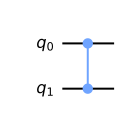

In [2]:
# a controlled-Z
qc.cz(c,t)
qc.draw()

where c and t are the control and target qubits. In IBM Q devices, however, the only kind of two-qubit gate that can be directly applied is the CNOT. We therefore need a way to transform one to the other.

The process for this is quite simple. We know that the Hadamard transforms the states $|0\rangle$ and $|1\rangle$ to the states $|+\rangle$ and $|-\rangle$ respectively. We also know that the effect of the $Z$ gate on the states $|+\rangle$ and $|-\rangle$ is the same as that for $X$ on the state $|0\rangle$ and $|1\rangle$. From this reasoning, or from simply multiplying matrices, we find that

$$
H X H = Z,\\\\
H Z H = X.
$$

The same trick can be used to transform a CNOT into a controlled-$Z$. All we need to do is precede and follow the CNOT with a Hadamard on the target qubit. This will transform any $X$ applied to that qubit into a $Z$.

In [2]:
qc = QuantumCircuit(2)
# also a controlled-Z
qc.h(t)
qc.cx(c,t)
qc.h(t)
qc.draw()

q_0: ───────■───────
     ┌───┐┌─┴─┐┌───┐
q_1: ┤ H ├┤ X ├┤ H ├
     └───┘└───┘└───┘

More generally, we can transform a single CNOT  into a controlled version of any rotation around the Bloch sphere by an angle $\pi$, by simply preceding and following it with the correct rotations. For example, a controlled-$Y$:

In [3]:
qc = QuantumCircuit(2)
# a controlled-Y
qc.sdg(t)
qc.cx(c,t)
qc.s(t)
qc.draw()

q_0: ─────────■───────
     ┌─────┐┌─┴─┐┌───┐
q_1: ┤ SDG ├┤ X ├┤ S ├
     └─────┘└───┘└───┘

and a controlled-$H$:

In [4]:
qc = QuantumCircuit(2)
# a controlled-H
qc.ry(pi/4,t)
qc.cx(c,t)
qc.ry(-pi/4,t)
qc.draw()

q_0: ─────────────■──────────────
     ┌─────────┐┌─┴─┐┌──────────┐
q_1: ┤ RY(π/4) ├┤ X ├┤ RY(-π/4) ├
     └─────────┘└───┘└──────────┘

## 2. Swapping Qubits <a id="swapping"></a>

In [5]:
a = 0
b = 1

Sometimes we need to move information around in a quantum computer. For some qubit implementations, this could be done by physically moving them. Another option is simply to move the state between two qubits. This is done by the SWAP gate.

In [6]:
qc = QuantumCircuit(2)
# swaps states of qubits a and b
qc.swap(a,b)
qc.draw()

q_0: ─X─
      │ 
q_1: ─X─

The command above directly invokes this gate, but let's see how we might make it using our standard gate set. For this, we'll need to consider a few examples.

First, we'll look at the case that qubit a is in state $|1\rangle$ and qubit b is in state $|0\rangle$. For this we'll apply the following gates:

In [7]:
qc = QuantumCircuit(2)
# swap a 1 from a to b
qc.cx(a,b) # copies 1 from a to b
qc.cx(b,a) # uses the 1 on b to rotate the state of a to 0
qc.draw()

┌───┐
q_0: ──■──┤ X ├
     ┌─┴─┐└─┬─┘
q_1: ┤ X ├──■──
     └───┘

This has the effect of putting qubit b in state $|1\rangle$ and qubit a in state $|0\rangle$. In this case at least, we have done a SWAP.

Now let's take this state and SWAP back to the original one. As you may have guessed, we can do this with the reverse of the above process:

In [8]:
# swap a q from b to a
qc.cx(b,a) # copies 1 from b to a
qc.cx(a,b) # uses the 1 on a to rotate the state of b to 0
qc.draw()

┌───┐┌───┐     
q_0: ──■──┤ X ├┤ X ├──■──
     ┌─┴─┐└─┬─┘└─┬─┘┌─┴─┐
q_1: ┤ X ├──■────■──┤ X ├
     └───┘          └───┘

Note that in these two processes, the first gate of one would have no effect on the initial state of the other. For example, when we swap the $|1\rangle$ b to a, the first gate is `cx(b,a)`. If this were instead applied to a state where no $|1\rangle$ was initially on b, it would have no effect.

Note also that for these two processes, the final gate of one would have no effect on the final state of the other. For example, the final `cx(b,a)` that is required when we swap the $|1\rangle$ from a to b has no effect on the state where the $|1\rangle$ is not on b.

With these observations, we can combine the two processes by adding an ineffective gate from one onto the other. For example,

In [9]:
qc = QuantumCircuit(2)
qc.cx(b,a)
qc.cx(a,b)
qc.cx(b,a)
qc.draw()

┌───┐     ┌───┐
q_0: ┤ X ├──■──┤ X ├
     └─┬─┘┌─┴─┐└─┬─┘
q_1: ──■──┤ X ├──■──
          └───┘

We can think of this as a process that swaps a $|1\rangle$ from a to b, but with a useless `qc.cx(b,a)` at the beginning. We can also think of it as a process that swaps a $|1\rangle$ from b to a, but with a useless `qc.cx(b,a)` at the end. Either way, the result is a process that can do the swap both ways around.

It also has the correct effect on the $|00\rangle$ state. This is symmetric, and so swapping the states should have no effect. Since the CNOT gates have no effect when their control qubits are $|0\rangle$, the process correctly does nothing.

The $|11\rangle$ state is also symmetric, and so needs a trivial effect from the swap. In this case, the first CNOT gate in the process above will cause the second to have no effect, and the third undoes the first. Therefore, the whole effect is indeed trivial.

We have thus found a way to decompose SWAP gates into our standard gate set of single-qubit rotations and CNOT gates.

In [10]:
qc = QuantumCircuit(2)
# swaps states of qubits a and b
qc.cx(b,a)
qc.cx(a,b)
qc.cx(b,a)
qc.draw()

┌───┐     ┌───┐
q_0: ┤ X ├──■──┤ X ├
     └─┬─┘┌─┴─┐└─┬─┘
q_1: ──■──┤ X ├──■──
          └───┘

It works for the states $|00\rangle$, $|01\rangle$, $|10\rangle$ and $|11\rangle$, and if it works for all the states in the computational basis, it must work for all states generally. This circuit therefore swaps all possible two-qubit states.

The same effect would also result if we changed the order of the CNOT gates:

In [11]:
qc = QuantumCircuit(2)
# swaps states of qubits a and b
qc.cx(a,b)
qc.cx(b,a)
qc.cx(a,b)
qc.draw()

┌───┐     
q_0: ──■──┤ X ├──■──
     ┌─┴─┐└─┬─┘┌─┴─┐
q_1: ┤ X ├──■──┤ X ├
     └───┘     └───┘

This is an equally valid way to get the SWAP gate.

The derivation used here was very much based on the z basis states, but it could also be done by thinking about what is required to swap qubits in states $|+\rangle$ and $|-\rangle$. The resulting ways of implementing the SWAP gate will be completely equivalent to the ones here.

#### Quick Exercise:
- Find different circuit that swaps qubits in the states $|+\rangle$ and $|-\rangle$, and show this is equivalent to the circuit shown above.

## 3. Controlled Rotations <a id="controlled-rotations"></a>

We have already seen how to build controlled $\pi$ rotations from a single CNOT gate. Now we'll look at how to build any controlled rotation.

First, let's consider arbitrary rotations around the y axis. Specifically, consider the following sequence of gates.

In [12]:
qc = QuantumCircuit(2)
theta = pi # theta can be anything (pi chosen arbitrarily)
qc.ry(theta/2,t)
qc.cx(c,t)
qc.ry(-theta/2,t)
qc.cx(c,t)
qc.draw()

q_0: ─────────────■────────────────■──
     ┌─────────┐┌─┴─┐┌──────────┐┌─┴─┐
q_1: ┤ RY(π/2) ├┤ X ├┤ RY(-π/2) ├┤ X ├
     └─────────┘└───┘└──────────┘└───┘

If the control qubit is in state $|0\rangle$, all we have here is a $R_y(\theta/2)$ immediately followed by its inverse, $R_y(-\theta/2)$. The end effect is trivial. If the control qubit is in state $|1\rangle$, however, the `ry(-theta/2)` is effectively preceded and followed by an X gate. This has the effect of flipping the direction of the y rotation and making a second $R_y(\theta/2)$. The net effect in this case is therefore to make a controlled version of the rotation $R_y(\theta)$. 

This method works because the x and y axis are orthogonal, which causes the x gates to flip the direction of the rotation. It therefore similarly works to make a controlled $R_z(\theta)$. A controlled $R_x(\theta)$ could similarly be made using CNOT gates.

We can also make a controlled version of any single-qubit rotation, $V$. For this we simply need to find three rotations A, B and C, and a phase $\alpha$ such that

$$
ABC = I, ~~~e^{i\alpha}AZBZC = V
$$

We then use controlled-Z gates to cause the first of these relations to happen whenever the control is in state $|0\rangle$, and the second to happen when the control is state $|1\rangle$. An $R_z(2\alpha)$ rotation is also used on the control to get the right phase, which will be important whenever there are superposition states.

In [13]:
A = Gate('A', 1, [])
B = Gate('B', 1, [])
C = Gate('C', 1, [])
alpha = 1 # arbitrarily define alpha to allow drawing of circuit

In [14]:
qc = QuantumCircuit(2)
qc.append(C, [t])
qc.cz(c,t)
qc.append(B, [t])
qc.cz(c,t)
qc.append(A, [t])
qc.p(alpha,c)
qc.draw()

┌──────┐
q_0: ──────■───────■─┤ P(1) ├
     ┌───┐ │ ┌───┐ │ └┬───┬─┘
q_1: ┤ C ├─■─┤ B ├─■──┤ A ├──
     └───┘   └───┘    └───┘

![A controlled version of a gate V](images/iden1.png)

Here `A`, `B` and `C` are gates that implement $A$ , $B$ and $C$, respectively.

## 4. The Toffoli <a id="ccx"></a>

The Toffoli gate is a three-qubit gate with two controls and one target. It performs an X on the target only if both controls are in the state $|1\rangle$. The final state of the target is then equal to either the AND or the NAND of the two controls, depending on whether the initial state of the target was $|0\rangle$ or $|1\rangle$. A Toffoli can also be thought of as a controlled-controlled-NOT, and is also called the CCX gate.

In [15]:
qc = QuantumCircuit(3)
a = 0
b = 1
t = 2
# Toffoli with control qubits a and b and target t
qc.ccx(a,b,t)
qc.draw()

q_0: ──■──
       │  
q_1: ──■──
     ┌─┴─┐
q_2: ┤ X ├
     └───┘

To see how to build it from single- and two-qubit gates, it is helpful to first show how to build something even more general: an arbitrary controlled-controlled-U for any single-qubit rotation U. For this we need to define controlled versions of $V = \sqrt{U}$ and $V^\dagger$. In the code below, we use `cp(theta,c,t)` and `cp(-theta,c,t)`in place of the undefined subroutines `cv` and `cvdg` respectively. The controls are qubits $a$ and $b$, and the target is qubit $t$.

In [16]:
qc = QuantumCircuit(3)
qc.cp(theta,b,t)
qc.cx(a,b)
qc.cp(-theta,b,t)
qc.cx(a,b)
qc.cp(theta,a,t)
qc.draw()

q_0: ─────────■────────────■───■─────
            ┌─┴─┐        ┌─┴─┐ │     
q_1: ─■─────┤ X ├─■──────┤ X ├─┼─────
      │P(π) └───┘ │P(-π) └───┘ │P(π) 
q_2: ─■───────────■────────────■─────

![A doubly controlled version of a gate V](images/iden2.png)

By tracing through each value of the two control qubits, you can convince yourself that a U gate is applied to the target qubit if and only if both controls are 1. Using ideas we have already described, you could now implement each controlled-V gate to arrive at some circuit for the doubly-controlled-U gate. It turns out that the minimum number of CNOT gates required to implement the Toffoli gate is six [2].


![A Toffoli](images/iden3.png)
*This is a Toffoli with 3 qubits(q0,q1,q2) respectively. In this circuit example, q0 is connected with q2 but q0 is not connected with q1.


The Toffoli is not the unique way to implement an AND gate in quantum computing. We could also define other gates that have the same effect, but which also introduce relative phases. In these cases, we can implement the gate with fewer CNOTs.

For example, suppose we use both the controlled-Hadamard and controlled-$Z$ gates, which can both be implemented with a single CNOT. With these we can make the following circuit:

In [17]:
qc = QuantumCircuit(3)
qc.ch(a,t)
qc.cz(b,t)
qc.ch(a,t)
qc.draw()

q_0: ──■───────■──
       │       │  
q_1: ──┼───■───┼──
     ┌─┴─┐ │ ┌─┴─┐
q_2: ┤ H ├─■─┤ H ├
     └───┘   └───┘

For the state $|00\rangle$ on the two controls, this does nothing to the target. For $|11\rangle$, the target experiences a $Z$ gate that is both preceded and followed by an H. The net effect is an $X$ on the target. For the states $|01\rangle$ and $|10\rangle$, the target experiences either just the two Hadamards \(which cancel each other out\) or just the $Z$ \(which only induces a relative phase\). This therefore also reproduces the effect of an AND, because the value of the target is only changed for the $|11\rangle$ state on the controls -- but it does it with the equivalent of just three CNOT gates.

## 5. Arbitrary rotations from H and T <a id="arbitrary-rotations"></a>

The qubits in current devices are subject to noise, which basically consists of gates that are done by mistake. Simple things like temperature, stray magnetic fields or activity on neighboring qubits can make things happen that we didn't intend.

For large applications of quantum computers, it will be necessary to encode our qubits in a way that protects them from this noise. This is done by making gates much harder to do by mistake, or to implement in a manner that is slightly wrong.

This is unfortunate for the single-qubit rotations $R_x(\theta)$, $R_y(\theta)$ and $R_z(\theta)$. It is impossible to implement an angle $\theta$ with perfect accuracy, such that you are sure that you are not accidentally implementing something like $\theta + 0.0000001$. There will always be a limit to the accuracy we can achieve, and it will always be larger than is tolerable when we account for the build-up of imperfections over large circuits. We will therefore not be able to implement these rotations directly in fault-tolerant quantum computers, but will instead need to build them in a much more deliberate manner.

Fault-tolerant schemes typically perform these rotations using multiple applications of just two gates: $H$ and $T$.

The T gate is expressed in Qiskit as `.t()`:

In [18]:
qc = QuantumCircuit(1)
qc.t(0) # T gate on qubit 0
qc.draw()

┌───┐
q_0: ┤ T ├
     └───┘

It is a rotation around the z axis by $\theta = \pi/4$, and so is expressed mathematically as $R_z(\pi/4) = e^{i\pi/8~Z}$.

In the following we assume that the $H$ and $T$ gates are effectively perfect. This can be engineered by suitable methods for error correction and fault-tolerance.

Using the Hadamard and the methods discussed in the last chapter, we can use the T gate to create a similar rotation around the x axis.

In [19]:
qc = QuantumCircuit(1)
qc.h(0)
qc.t(0)
qc.h(0)
qc.draw()

┌───┐┌───┐┌───┐
q_0: ┤ H ├┤ T ├┤ H ├
     └───┘└───┘└───┘

Now let's put the two together. Let's make the gate $R_z(\pi/4)~R_x(\pi/4)$.

In [20]:
qc = QuantumCircuit(1)
qc.h(0)
qc.t(0)
qc.h(0)
qc.t(0)
qc.draw()

┌───┐┌───┐┌───┐┌───┐
q_0: ┤ H ├┤ T ├┤ H ├┤ T ├
     └───┘└───┘└───┘└───┘

Since this is a single-qubit gate, we can think of it as a rotation around the Bloch sphere. That means that it is a rotation around some axis by some angle. We don't need to think about the axis too much here, but it clearly won't be simply x, y or z. More important is the angle.

The crucial property of the angle for this rotation is that it is an irrational multiple of $\pi$. You can prove this yourself with a bunch of math, but you can also see the irrationality in action by applying the gate. Keeping in mind that everytime we apply a rotation that is larger than $2\pi$, we are doing an implicit modulous by $2\pi$ on the rotation angle. Thus, repeating the combined rotation mentioned above $n$ times results in a rotation around the same axis by a different angle. As a hint to a rigorous proof, recall that an irrational number cannot be be written as what?

We can use this to our advantage. Each angle will be somewhere between $0$ and $2\pi$. Let's split this interval up into $n$ slices of width $2\pi/n$. For each repetition, the resulting angle will fall in one of these slices. If we look at the angles for the first $n+1$ repetitions, it must be true that at least one slice contains two of these angles due to the pigeonhole principle. Let's use $n_1$ to denote the number of repetitions required for the first, and $n_2$ for the second.

With this, we can prove something about the angle for $n_2-n_1$ repetitions. This is effectively the same as doing $n_2$ repetitions, followed by the inverse of $n_1$ repetitions. Since the angles for these are not equal \(because of the irrationality\) but also differ by no greater than $2\pi/n$ \(because they correspond to the same slice\), the angle for $n_2-n_1$ repetitions satisfies

$$
\theta_{n_2-n_1} \neq 0, ~~~~-\frac{2\pi}{n} \leq \theta_{n_2-n_1} \leq \frac{2\pi}{n} .
$$

We therefore have the ability to do rotations around small angles. We can use this to rotate around angles that are as small as we like, just by increasing the number of times we repeat this gate.

By using many small-angle rotations, we can also rotate by any angle we like. This won't always be exact, but it is guaranteed to be accurate up to $2\pi/n$, which can be made as small as we like. We  now have power over the inaccuracies in our rotations.

So far, we only have the power to do these arbitrary rotations around one axis. For a second axis, we simply do the $R_z(\pi/4)$ and $R_x(\pi/4)$ rotations in the opposite order.

In [21]:
qc = QuantumCircuit(1)
qc.t(0)
qc.h(0)
qc.t(0)
qc.h(0)
qc.draw()

┌───┐┌───┐┌───┐┌───┐
q_0: ┤ T ├┤ H ├┤ T ├┤ H ├
     └───┘└───┘└───┘└───┘

The axis that corresponds to this rotation is not the same as that for the gate considered previously. We therefore now have arbitrary rotation around two axes, which can be used to generate any arbitrary rotation around the Bloch sphere. We are back to being able to do everything, though it costs quite a lot of $T$ gates.

It is because of this kind of application that $T$ gates are so prominent in quantum computation. In fact, the complexity of algorithms for fault-tolerant quantum computers is often quoted in terms of how many $T$ gates they'll need. This motivates the quest to achieve things with as few $T$ gates as possible. Note that the discussion above was simply intended to prove that $T$ gates can be used in this way, and does not represent the most efficient method we know.

## 6. References <a id="references"></a>

[1] [Barenco, *et al.* 1995](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.52.3457?cm_mc_uid=43781767191014577577895&cm_mc_sid_50200000=1460741020)

[2] [Shende and Markov, 2009](http://dl.acm.org/citation.cfm?id=2011799)

In [23]:
import qiskit
qiskit.__qiskit_version__

{'qiskit-terra': '0.16.1',
 'qiskit-aer': '0.7.2',
 'qiskit-ignis': '0.5.1',
 'qiskit-ibmq-provider': '0.11.1',
 'qiskit-aqua': '0.8.1',
 'qiskit': '0.23.2'}